## CNN (Convoluted Neural Networks)

* CNN emualates human visiob system 
* components to extract different features
* Image data is structured : edges,shapes,translation invariance,scale invariance
* Convolution (kernel/filter - grid of weights) & Pooling
* Architectural decisions for convolution - Grid size(kernel size-usually 3x3x3,5x5x5), Stride(step size user for sliding kernel on image-usually by 1 pixel), Depth(greyscale=1,colorimage=3) and no. of kernels (no.of outputs from convolutional layer is as many 2d arrays as the no.of kernels)
* Pooling - downsampling


#### How do I apply CNN to audio?

* Audio can be thought of an image > Spectogram/MFCC = image
* time frequency = x,y
* amplitude = pixel value
* 13 MFCCs, hop_length=512 # samples in audio file = 51200, Data shape = 100 x 13x 1
* Audio data can be compared to grey scale image, depth=1

In [1]:
import os
import librosa
import math
import json
import numpy as np
from sklearn.model_selection import train_test_split
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import tensorflow as tf
import matplotlib.pyplot as plt
import visualkeras

In [2]:
# loading mfcc data
def load_data(dataset_path):
    with open(dataset_path,'r') as fp:
        data = json.load(fp)
        
    #convert lists to numpy arrays
    inputs = np.array(data["mfcc"])
    targets = np.array(data["labels"])
    
    return inputs,targets

In [3]:
JSON_PATH = "./outputs/ravdess_complete.json"

In [4]:
# load the data
X,y = load_data(JSON_PATH)

In [5]:
X.shape,y.shape

((1438, 130, 13), (1438,))

In [6]:
#Emotion (0 = neutral, 1 = calm, 2 = happy, 3 = sad, 4 = angry, 5 = fearful, 6 = disgust, 7 = surprised)
# selecting only calm,happy,angry 

X = X[(y!=0)]
y = y[(y!=0)]
X = X[(y!=3)]
y = y[(y!=3)]
X = X[(y<=4)]
y = y[(y<=4)]


In [7]:
# So I have now 2,3 and 4 in the training > it needs to be 0,1,2
y = np.where(y==1, 0, y)

In [8]:
y = np.where(y==2, 1, y)

In [9]:
y = np.where(y==4, 2, y)

In [10]:
y.max()

2

In [11]:
y.shape, X.shape

((575,), (575, 130, 13))

In [12]:
# shape of each input entry : (number of samples per second/hop_length)*duration

In [13]:
def prepare_data(X,y,test_size,validation_size):
    
    # splitting data into train and test set
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=test_size)
    
    # splitting data into train and validation set
    X_train,X_validation,y_train,y_validation = train_test_split(X,y,test_size=validation_size)
    
    # add extra dimension , as sound files are treated like greyscale images
    X_train = X_train[...,np.newaxis] #4d array num_samples x 130 x 13 x 1
    X_test = X_test[...,np.newaxis]
    X_validation = X_validation[...,np.newaxis]
    return X_train,X_validation,X_test,y_train,y_validation,y_test

In [14]:
# splitting data into train,validation and test set
X_train,X_validation,X_test,y_train,y_validation,y_test = prepare_data(X,y,test_size=0.25,validation_size=0.2)

In [15]:
X_train.shape

(460, 130, 13, 1)

In [16]:
def build_model(input_shape):
    #create model
    model = tf.keras.Sequential()
    #model.add(tf.keras.layers.BatchNormalization())
    
    #1st conv layer
    model.add(tf.keras.layers.Conv2D(8,(3,3),activation="relu",input_shape=input_shape))
    model.add(tf.keras.layers.MaxPool2D((3,3),strides=(2,2),padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    
    #2nd conv layer
    #model.add(tf.keras.layers.Conv2D(32,(3,3),activation="relu",input_shape=input_shape))
    #model.add(tf.keras.layers.MaxPool2D((3,3),strides=(2,2),padding='same'))
    #model.add(tf.keras.layers.BatchNormalization())

    #3rd conv layer
    #model.add(tf.keras.layers.Conv2D(32,(2,2),activation="relu",input_shape=input_shape))
    #model.add(tf.keras.layers.MaxPool2D((2,2),strides=(2,2),padding='same'))
    #model.add(tf.keras.layers.BatchNormalization())
    
    #flatten and feed to dense layer
    model.add(tf.keras.layers.Flatten())
    #model.add(tf.keras.layers.InputLayer(input_shape=(3072,)))
    model.add(tf.keras.layers.Dense(64,activation="relu",input_shape=(3072,)))
    model.add(tf.keras.layers.Dropout(0.3))
    
    #output layer that feeds to softmax
    model.add(tf.keras.layers.Dense(3,activation="softmax"))
    
    return model
    

In [17]:
# building the CNN
input_shape = (X_train.shape[1],X_train.shape[2],X_train.shape[3])

model = build_model(input_shape)

model.compile(optimizer = tf.keras.optimizers.Adam(),loss="sparse_categorical_crossentropy",metrics=["accuracy"])


In [18]:
# fitting the model
history=model.fit(X_train,y_train,validation_data=(X_validation,y_validation),batch_size=32,epochs=100)

Epoch 1/100
15/15 [==============================] - 3s 108ms/step - loss: 1.5247 - accuracy: 0.4639 - val_loss: 1.0708 - val_accuracy: 0.6783
Epoch 2/100
15/15 [==============================] - 1s 44ms/step - loss: 0.7577 - accuracy: 0.6947 - val_loss: 1.0526 - val_accuracy: 0.6783
Epoch 3/100
15/15 [==============================] - 1s 44ms/step - loss: 0.5787 - accuracy: 0.7486 - val_loss: 0.8150 - val_accuracy: 0.6957
Epoch 4/100
15/15 [==============================] - 1s 44ms/step - loss: 0.4675 - accuracy: 0.8420 - val_loss: 0.9688 - val_accuracy: 0.6261
Epoch 5/100
15/15 [==============================] - 1s 40ms/step - loss: 0.4169 - accuracy: 0.8430 - val_loss: 0.8765 - val_accuracy: 0.6435
Epoch 6/100
15/15 [==============================] - 1s 43ms/step - loss: 0.3652 - accuracy: 0.8519 - val_loss: 0.8216 - val_accuracy: 0.6435
Epoch 7/100
15/15 [==============================] - 1s 49ms/step - loss: 0.3490 - accuracy: 0.8692 - val_loss: 0.6718 - val_accuracy: 0.7391
Epoch

15/15 [==============================] - 1s 37ms/step - loss: 0.0251 - accuracy: 0.9917 - val_loss: 0.4572 - val_accuracy: 0.8783
Epoch 59/100
15/15 [==============================] - 1s 40ms/step - loss: 0.0099 - accuracy: 1.0000 - val_loss: 0.4871 - val_accuracy: 0.8609
Epoch 60/100
15/15 [==============================] - 1s 51ms/step - loss: 0.0289 - accuracy: 0.9856 - val_loss: 0.4971 - val_accuracy: 0.8435
Epoch 61/100
15/15 [==============================] - 1s 36ms/step - loss: 0.0173 - accuracy: 0.9970 - val_loss: 0.4408 - val_accuracy: 0.8609
Epoch 62/100
15/15 [==============================] - 1s 37ms/step - loss: 0.0149 - accuracy: 0.9974 - val_loss: 0.5029 - val_accuracy: 0.8609
Epoch 63/100
15/15 [==============================] - 1s 38ms/step - loss: 0.0129 - accuracy: 0.9942 - val_loss: 0.5782 - val_accuracy: 0.8609
Epoch 64/100
15/15 [==============================] - 1s 46ms/step - loss: 0.0298 - accuracy: 0.9843 - val_loss: 0.6542 - val_accuracy: 0.8609
Epoch 65/100

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 11, 8)        80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 6, 8)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 6, 8)          32        
_________________________________________________________________
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                196672    
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1

In [66]:
import pandas as pd
pd.DataFrame(history.history["accuracy"]).to_csv('CNN_train_acc.csv')
pd.DataFrame(history.history["val_accuracy"]).to_csv('CNN_val_acc.csv')

In [20]:
#Evaluating the model
test_error,test_accuracy = model.evaluate(X_test,y_test,verbose=1)

5/5 [==============================] - 0s 16ms/step - loss: 0.0032 - accuracy: 1.0000


In [21]:
test_accuracy

1.0

In [22]:
#model.save('mfcc_only_model_calm_happy_angry.h5')

In [21]:
def predict(model,X):
    #X = X[np.newaxis,...] #size of X (1,130,13,1) [Conversion to be done if entering one value]
    prediction = model.predict(X) #prediction contains 3 values - probability for each genre [[0.1, 0.2, ..]]
    #print(prediction)
    #extract index with max value
    predicted_index = np.argmax(prediction,axis=1)
    return predicted_index

In [22]:
y_pred = predict(model,X_test)

In [45]:
#predicting the emotion from external audio
my_test_audio,sr =librosa.load('./test_audios/test_audio2.wav',sr=22050)
audio_duration = round(librosa.get_duration(my_test_audio),0)
std_duration = 3
mfcc_test = librosa.feature.mfcc(my_test_audio[:22050*std_duration],sr=22050,n_mfcc=13,n_fft=2048,hop_length=512)
mfcc_test = mfcc_test.T
mfcc_test = mfcc_test[np.newaxis,...,np.newaxis]
y_pred = predict(model,mfcc_test)
Emotions = {0:'calm', 1:'happy',2:'angry'}
Emotions[y_pred[0]]

'happy'

In [26]:
#y, sr = librosa.load(librosa.util.example_audio_file())
print(librosa.feature.chroma_stft(my_test_audio[:22050*3], sr=22050).shape)

(12, 130)


In [50]:
def plot_history(history):
    fig, axs = plt.subplots(2,figsize=(12,8))
    
    #create the accuracy subplot
    axs[0].plot(history.history["accuracy"],label="train accuracy")
    axs[0].plot(history.history["val_accuracy"],label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")
    
    #create the error subplot
    axs[1].plot(history.history["loss"],label="train error")
    axs[1].plot(history.history["val_loss"],label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")
    
    plt.show()   
    

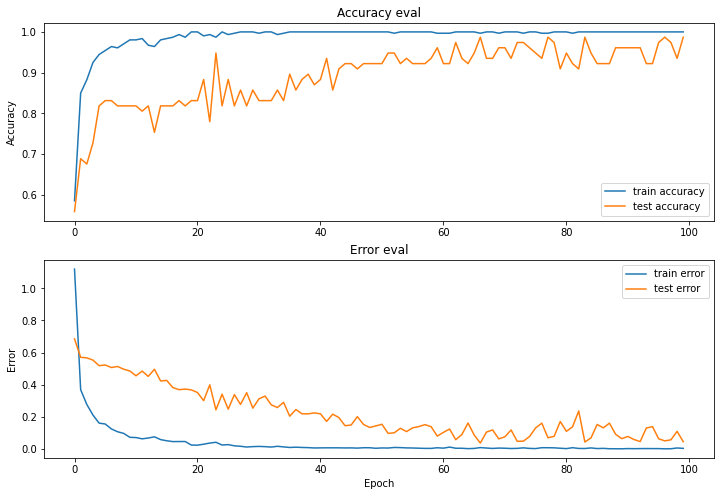

In [109]:
plot_history(history)

In [76]:
max(history.history['val_accuracy'])

0.8571428656578064

In [82]:
from sklearn.metrics import confusion_matrix

In [85]:
confusion_matrix(y_test,y_pred)

array([[43,  0],
       [ 2, 51]], dtype=int64)

In [86]:
y_train_pred = predict(model,X_train)

In [87]:
y_validation_pred = predict(model,X_validation)

In [88]:
confusion_matrix(y_train,y_train_pred)

array([[154,   0],
       [  0, 153]], dtype=int64)

In [89]:
confusion_matrix(y_validation,y_validation_pred)

array([[32,  6],
       [ 7, 32]], dtype=int64)

In [90]:
y_train.shape,y_test.shape,y_validation.shape

((307,), (96,), (77,))

In [91]:
(y_test==0).sum()

43

In [54]:
# Emotion (0 = neutral, 1 = calm, 2 = happy, 3 = sad, 4 = angry, 5 = fearful, 6 = disgust, 7 = surprised)